# Neural Networks Learning with Backpropagation and Gradient Checking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import random
import math
%matplotlib inline

## 1. Neural Networks 

### 1.1 Visualizing the data

Loading the MINST (images of handwritten numbers) dataset and showing random example visually. Once again, there are 5000 training examples and 400 features (pixel intensity). The output has 10 classes, with numbers ranging from 1 to 10 (0's represent 10 to make indexing easier). 

In [2]:
d = loadmat('Data/ex4data1.mat')
X, y = d['X'], d['y']
X = np.insert(X, 0, 1, axis=1)
X.shape, y.shape

((5000, 401), (5000, 1))

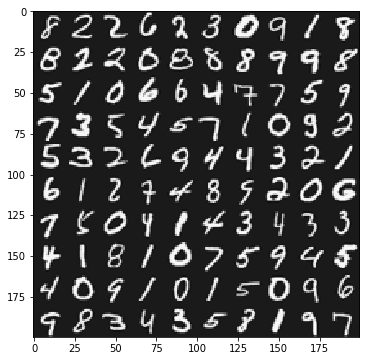

In [3]:
from graph import displayData
displayData(X)

### 1.2 Model Representation 

<img src='Description/Neural_Network_Model.png' alt="Drawing" style="width: 400px;"/>
My model is a 3 layer neural network where the inputs have 400 units of pixel values. The hidden layer has 25 units and the output layer has 10 units.

In [4]:
weights = loadmat('Data/ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print ('theta 1: %r\ntheta 2: %r') % (theta1.shape, theta2.shape)

theta 1: (25, 401)
theta 2: (10, 26)


In [5]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.concatenate((theta1.flatten(), theta2.flatten()))
print("unrolled theta: %r") % (nn_params.shape,)

unrolled theta: (10285,)


### 1.3 Feedforward and Regularized Cost Function 

This is the cost function: 
<img src="Description/Regularized_Cost_Function.png" alt="Drawing" style="width: 500px;"/>
where h$_\theta$(x) is the sigmoid function: 
$$g(z) = \frac{1}{1+e^{-z}}$$

In [6]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [7]:
def Feedforward_Propagation_3Layers(theta1, theta2, X):
    a1 = X #(5000,401)
    
    z2 = a1.dot(theta1.T) #(5000,25)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1) #(5000,26)
    z3 = a2.dot(theta2.T) #(5000,10)
    a3 = sigmoid(z3)

    return a1,z2,a2,z3,a3

In [8]:
from sklearn.preprocessing import OneHotEncoder 
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,\
                   num_labels, X, y, my_lambda):
    
    m = float(X.shape[0])
    
    #unrolling theta
    theta1 = np.reshape(nn_params[0:hidden_layer_size*(input_layer_size+1)]\
           ,(hidden_layer_size,input_layer_size+1))
    theta2 = np.reshape(nn_params[(hidden_layer_size*(input_layer_size+1)):] \
           ,(num_labels,hidden_layer_size+1))
    
    #hot encoding y
    encode = OneHotEncoder()  
    y_recode = encode.fit_transform(y).toarray()  
    
    #Run a Feedforward Propagation first
    a1,z2,a2,z3,h = Feedforward_Propagation_3Layers(theta1, theta2, X) 
    
    #Cost function:
    left_term = (-y_recode) * np.log(h)    #element-wise multiplication. Size: (5000,10)
    right_term = (1-y_recode) * np.log(1-h) #Size: (5000,10)
    J = (1/m) * np.sum(left_term - right_term)    #Sum of K and sum of i
    #Regularized terms:
    reg = np.sum(np.power(theta1[:,1:],2)) + np.sum(np.power(theta2[:,1:],2))
    J += ((my_lambda)/(2*m)) * reg

    return J

In [9]:
my_lambda = 1
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,\
                   num_labels, X, y, my_lambda)
print("Cost at parameters with lambda = 1: %r") % J
print("The expected cost value should be 0.383770")

Cost at parameters with lambda = 1: 0.38376985909092365
The expected cost value should be 0.383770


## 2. Backpropagation 

### 2.1 Sigmoid Gradient

To get the gradient, I first need the derivative of the sigmoid: 
$$g^{'}(z) = \frac{d}{dz}g(z) = g(z)(1-g(z))$$

In [10]:
def sigmoidGradient(z):
    g_prime = sigmoid(z) * (1 - sigmoid(z))
    return g_prime

### 2.2 Random Initialization

Initializing parameters randomly between 0 and 1.

In [11]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = np.random.random((L_in, 1 + L_out)) * (2*epsilon_init) - epsilon_init
    return W

### 2.3 Backpropagation (Regularized)

<img src='Description/Backprop_updates.png' alt="Drawing" style="width: 500px"/>

The backpropagation takes in the same parameters as the cost function and returns an unrolled gradient matrix. 
(Note in the backpropagation update, '.*' denotes elementwise multiplication and the other products are matrix multiplication.)

Regularization is as follows and it doesn't apply to the bias term:
<img src='Description/Regularization_NN.png' alt="Drawing" style="width: 400px;"/>

In [12]:
def gradient(nn_params, input_layer_size, hidden_layer_size,\
                   num_labels, X, y, my_lambda):
    m = float(X.shape[0])
    
    #unrolling theta
    theta1 = np.reshape(nn_params[0:hidden_layer_size*(input_layer_size+1)]\
           ,(hidden_layer_size,input_layer_size+1))
    theta2 = np.reshape(nn_params[(hidden_layer_size*(input_layer_size+1)):] \
           ,(num_labels,hidden_layer_size+1))
    
    #hot encoding y
    encode = OneHotEncoder()  
    y_recode = encode.fit_transform(y).toarray()  
    
    #Forward Propagation
    a1,z2,a2,z3,h = Feedforward_Propagation_3Layers(theta1, theta2, X) 
    
    #Gradient (Backpropagation):
    Delta1 = np.zeros((hidden_layer_size, input_layer_size + 1))
    Delta2 = np.zeros((num_labels, hidden_layer_size + 1))
    
    d3 = h - y_recode                                   #(5000,10)
    d2 = d3.dot(theta2[:,1:]) * sigmoidGradient(z2)     #(5000,25)
    Delta1 = (d2.T).dot(a1)                            #(25,401)
    Delta2 = (d3.T).dot(a2)                            #(10,26)
    
    #Gradient update
    theta1_grad = (1/m) * Delta1
    theta2_grad = (1/m) * Delta2
    
    #Regularization on top of the update
    theta1_grad[:, 1:] += my_lambda/m *  theta1[:, 1:]
    theta2_grad[:, 1:] += my_lambda/m *  theta2[:, 1:]
    
    grad = np.concatenate((theta1_grad.flatten(),theta2_grad.flatten()))
    
    return grad

### 2.4 Gradient Checking

To make sure my backpropagation algorithm is working correctly, I compare it against a numerical method:
<img src='Description/Gradient_Checking.png' alt="Drawing" style="width: 200px;"/>
This is geomatrical method of finding a slope. Each corresponding theta feature out of 38 is added and subtracted by a very small number to get the almost instantaneous slope. Because this is a very expensive process, I'm only checking a small random sample.

In [13]:
def computeNumericalGradient(J, nn_params):
    numgrad = np.zeros(nn_params.shape)
    perturb = np.zeros(nn_params.shape)
    epsilon = 10**(-4)

    for p in range(1, np.size(nn_params)):
        perturb[p] = epsilon
        loss1 = J(nn_params - perturb)
        loss2 = J(nn_params + perturb)

        numgrad[p] = (loss2 - loss1) / (2 * epsilon)
        perturb[p] = 0

    return numgrad

In [14]:
def checkNNGradients(my_lambda):
    m = 5
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3

    theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
    theta2 = randInitializeWeights(num_labels, hidden_layer_size)
    nn_params = np.concatenate((theta1.flatten(), theta2.flatten()))
    
    X = np.random.rand(m, input_layer_size)
    X = np.insert(X, 0, 1, axis=1)
    y = np.array([[1], [2], [0], [1], [2]])
    
    numgrad = computeNumericalGradient(lambda nn_params: \
                                       nnCostFunction(nn_params, \
                                                      input_layer_size, \
                                                      hidden_layer_size, \
                                                      num_labels, X, y, \
                                                      my_lambda),nn_params)
    grad = gradient(nn_params, input_layer_size, hidden_layer_size,\
                   num_labels, X, y, my_lambda)
    
    print('Numerical Gradient','Analytical Gradient')
    for count in range(np.size(numgrad)):
        if (count) % 5 == 0:
            print(numgrad[count],grad[count])
            
    diff = np.linalg.norm(numgrad-grad) / np.linalg.norm(numgrad+grad)
    print('Relative Difference: %r \nThe difference should be small (less than 1e-9)') % diff

In [15]:
checkNNGradients(1)

('Numerical Gradient', 'Analytical Gradient')
(0.0, -0.0065173607429324411)
(0.014587445136271526, 0.014587445140119252)
(-0.01977051287349596, -0.019770512868664433)
(0.020089754817487204, 0.020089754818555947)
(0.29755271905740344, 0.29755271905435382)
(0.13530423945029568, 0.13530423944869369)
(0.0042516398091052565, 0.0042516398062549428)
(0.064811152897803481, 0.064811152897173374)
Relative Difference: 0.0067730752078330536 
The difference should be small (less than 1e-9)


The difference is nowhere near 1e-9, but it should be small enough to show that my backpropagation is wokring.

### 2.5 Learning Parameters Using Conjugate Gradient 

In [16]:
#Random Parameters Initialization
theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
theta2 = randInitializeWeights(num_labels, hidden_layer_size)
nn_params = np.concatenate((theta1.flatten(), theta2.flatten()))

my_lambda = 1

#Settings for minimization such as maximum iterations 
settings = {'maxiter' : 500, 'disp': True}

#Using conjugate gradient method
opt_result = opt.minimize(fun=nnCostFunction, x0=nn_params, \
             args=(input_layer_size, hidden_layer_size, num_labels, \
                   X, y, my_lambda), \
             method='CG', jac=gradient, options = settings)
opt_theta = opt_result.x

         Current function value: 0.310897
         Iterations: 500
         Function evaluations: 1072
         Gradient evaluations: 1072


In [17]:
def accuracy_nn(nn_params, X, y):
    theta1 = np.reshape(nn_params[0:hidden_layer_size*(input_layer_size+1)]\
           ,(hidden_layer_size,input_layer_size+1))
    theta2 = np.reshape(nn_params[(hidden_layer_size*(input_layer_size+1)):] \
           ,(num_labels,hidden_layer_size+1))
    
    a1,z2,a2,z3,h = Feedforward_Propagation_3Layers(theta1, theta2, X)
    
    p = np.argmax(h, axis =1) + 1
    
    correct = sum([1 if (est == actual) else 0 for (est,actual) in zip(p,y)])
    a = float(correct)/len(X) * 100.0
    
    return float(a)

print("The accuracy of this model is %r%%") % accuracy_nn(opt_theta, X, y)

The accuracy of this model is 99.58%


This accuracy of 99.5% is far higher than the 95.3% result in the assignment and this cost of 0.31 is also lower than 0.38, the cost of the given optimized parameters from earlier. However, this model may be overfitted and I might need to increase the regularization parameter.

## 3. Visualizing the Hidden Layer 

In [18]:
def display_hidden_layer(X, example_width=None):
#DISPLAYDATA Display 2D data in a nice grid

    # turns 1D X array into 2D
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))

    # Set example_width automatically if not passed in
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))

    # Gray Image
    plt.set_cmap("gray")

    # Compute rows, cols
    m, n = X.shape
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = -np.ones((pad + display_rows * (example_height + pad),  pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    curr_ex = 1
    for j in xrange(1,display_rows+1):
        for i in xrange (1,display_cols+1):
            if curr_ex > m:
                break


            # Get the max value of the patch to normalize all examples
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width ))

            # Basic (vs. advanced) indexing/slicing is necessary so that we look can assign
            # values directly to display_array and not to a copy of its subarray.
            # from stackoverflow.com/a/7960811/583834 and 
            # bytes.com/topic/python/answers/759181-help-slicing-replacing-matrix-sections
            # Also notice the order="F" parameter on the reshape call - this is because python's 
            # default reshape function uses "C-like index order, with the last axis index 
            # changing fastest, back to the first axis index changing slowest" i.e. 
            # it first fills out the first row/the first index, then the second row, etc. 
            # matlab uses "Fortran-like index order, with the first index changing fastest, 
            # and the last index changing slowest" i.e. it first fills out the first column, 
            # then the second column, etc. This latter behaviour is what we want.
            # Alternatively, we can keep the deault order="C" and then transpose the result
            # from the reshape call.
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (example_height, example_width), order="F") / max_val
            curr_ex += 1

        if curr_ex > m:
            break

    # Display Image
    h = plt.imshow(display_array, vmin=-1, vmax=1)

    # Do not show axis
    plt.axis('off')

    plt.show(block=False)

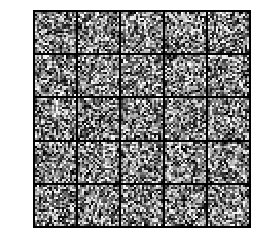

In [19]:
display_hidden_layer(theta1[:,1:])